This tutorial explains the main features of `SKQudit` and gives details about its implementation. Besides the import cell below, each of the numbered sections can be run separately.

In [1]:
# External imports
import numpy as np
import time

# skqudit import
from skqudit import (
    InstructionSet,
    CompiledGate,
    SimpleNet,
    solovay_kitaev
)
from skqudit.utils import (
    Rx,
    Rz,
    su2_matrix,
    plot_history,
    gell_mann_su3,
    su_matrix
)

# 1. The Solovay-Kitaev algorithm
We will here describe the details of Solovay-Kitaev algorithm as in the version by [Dawrson and Nielsen](https://arxiv.org/abs/quant-ph/0505030). To keep things simpler for the general practitioner of quantum computing, in this example, we will only consider only qubits -- that is, we will assume that our goal is to approximate a matrix in $SU(2)$ using only single qubit gates -- and leave the qudit case for the next section.

## 1.1 Quantum compilation
The gate-based paradigm of quantum computing consists of combining elements of some finite set of gates, also called *instructions*, to represent arbitrary $2\times 2$ special unitary matrices, said to live in the group $SU(2)$. Writing a general matrix $U$ in $SU(2)$ as (approximately) a product of instruction gates is known as *quantum compilation*. In particular, once $U$ is compiled, one can equivalently write it as the sequence of instructions, which is exactly the information sent to the [QPU](https://www.ibm.com/think/topics/qpu) and that is implemented in the hardware.

In `SKQudit`, instructions are represented as the object `InstructionSet`. This object is created by taking a dictionary with the instruction names and its matrices representations. No inverses are necessary to initialize the instruction set, these are computed automatically. Once computed, the inverses are represented by the captalized version of the instruction name (e.g., 'S1' is the inverse gate of 's1'). The only requirement is that the instructions are special unitary matrices, that is, we ask for them to be matrices of determinant $+1$ in addition to the unitary property.

In this example, we will use $R_X(\sqrt{2})$ and $R_Z(\sqrt{3})$, that is, a rotation by $\sqrt{2}$ radians along the $X$-axis of the Bloch sphere and a rotation of $\sqrt{3}$ radians along the $Z$-axis. 

In [2]:
s1 = Rx(np.sqrt(2))
s2 = Rz(np.sqrt(3))

instr = {
    's1': s1,
       's2': s2
       }
instr_set = InstructionSet(instr)
print('Instructions: ', instr_set.instrs)

Instructions:  ['s1', 's2', 'S1', 'S2']


Notice that the inverse gates were indeed added to the instruction set. For a long time, the development of a version of SK that does not require inverse gates was a big open problem in theoretical quantum computing, but that was recently solved by [Bouland and Giurgica-Tiro](https://arxiv.org/abs/2112.02040). Our implementation of the algorithm, however, requires inverse.

Once the instructions have been defined, they can be used to compile gates. For such, we refer to the class `CompiledGate`. Let us show an example of this class by considering a circuit that first applies $R_X(\sqrt{2})$, followed by $R_Z(\sqrt{3})$, and $R_X^{-1}(\sqrt{2})$ to a single qubit.

In [3]:
gate = CompiledGate('s1.s2.S1', instr_set)

We can check that this really compiles the expected circuit by considering the total unitary that it represents.

In [4]:
# Matrix product is assumed in the opposite
# order of the gate application
product = s1.conj().T @ s2 @ s1
assert np.allclose(gate.total_unitary, product)

## 1.2 Nets
In the example above, we worked on the direct problem: we had as input a sequence of instructions and computed the desired matrix. In practice, the inverse problem is what we are really intrested about: suppose we are given a matrix in $SU(2)$, can we find a compilation (as in sequence of instructions), which approximates that matrix? Finding such a sequence is exactly the goal of SK.

The first natural question to investigate the inverse problem is whether it really can be solved, that is, whether we can find such an approximate compilation. To characterize instructions sets for which the inverse problem can always be solved, we say that the instruction set is *universal* if there is a compilation that approximate any matrix in $SU(2)$ within any desired level of accuracy. Mathematically, universality can be characterized by the fact that the set of all compilations up to arbitrary lengths is *dense* in $SU(2)$. The instruction set created above is an example of a universal set.

Density itself already gives a very brute force possibility to compute compilations of matrices in $SU(2)$. For such, we define a $L$-net $\mathcal{N}$ as the set of all possible compilations of gates of length at most $L$. For example, in the example above, a 2-net is $\mathcal{N}=\{s1, s2, S1, S2, s1.s1, s1.s2,...,S2.s2\}$. We can simply iterate the net to find an approximation of any desired gate. The code below does just thatuses a 13-net to find an approximation of some matrix in $SU(2)$. Here, we will assume that the matrix to approximate is given by
$$
\exp(i\sigma_X + 2i \sigma_Y + 2i \sigma_Z)
$$
where $\sigma_X, \sigma_Y$ and $\sigma_Z$ are the [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices) in $SU(2)$.

In [5]:
# This code snippet can take up to a minute to run
# If you want to speed it up or do not have enough memory, reduce the number of layers 

# Layers is the number of layers we want to build on top of a
# 1-net (i.e., {s1, s2, S1, S2})
layers = 12
net = SimpleNet(instr_set)

_ = net.build_net(layers, verbosity=1)

print('\nSize of net:', len(net.net))

matrix_to_approximate = su2_matrix(1, 2, 2)

compilation, gate_dist = net.search(matrix_to_approximate,
           distance=0.1, # This paraemeter controls how close the compilation has to be to the target matrix
           method='full') # This ensures that we get the best approximate compilation

print('\nBest compilation found: ', compilation.instr)
print('Distance from compilation to target: ', round(gate_dist, 3))

Progress: layer 13 of 13

Size of net: 3188644
|█████████████████████████████-| 99.7%
Best compilation found:  s1.S2.s1.s1.s1.s2.s2.s1.S2.S2.S2.s1
Distance from compilation to target:  0.022


We were able to find a compilation that approximates the matrix at a distance -- or *accuracy* -- of $0.022$ (here and throughout, distances and inner-products between matrices are all measured using the [Frobenius norm](https://en.wikipedia.org/wiki/Frobenius_inner_product), that is, $\langle U, V\rangle = \text{tr}(U^\dagger V)$). For reasons that will soon become clear, we will call an $L$-net a $\epsilon_0$-net if any matrices of $SU(2)$ can be approximated by an element of the net with distance, at most, $\epsilon_0$. So, the net above is an $\epsilon_0$-net for some $\epsilon_0 \geq 0.022$. 

Note that $0.022$ is much smaller than our desired level of accuracy, $0.1$. So, if our goal is to find *any* approximation of the gate within distance at most $0.1$ -- and not the best one --, we can run the search with early exit, significantly reducing computational time.

In [6]:
compilation, gate_dist = net.search(matrix_to_approximate,
           distance=0.1,
           method='early_exit')

print('\nBest compilation found: ', compilation.instr)
print('Distance from compilation to target: ', round(gate_dist, 3))

|------------------------------| 1.3%
Best compilation found:  s1.s1.S2.S2.s1.s1.s1.S2.S2.s1
Distance from compilation to target:  0.06


Indeed much faster!

## 1.3 The Solovay-Kitaev algorithm
We can always search an $\epsilon_0$ to find an approximation of a gate with accuracy $\epsilon_0$, but, what if we need to approximate the gate within some $\epsilon$ strictly smaller than this $\epsilon_0$? In theory, one could generate a deeper net and, because the instructions are assumed to form a universal set of gates, we are guaranteed to eventually be able to find a long enough compilation to hit the desired distance. Nontheless, not only is this method naturally slow, but we would seem get out of memory if we try to force our way towards larger and larger nets.

Solovay-Kitaev offers a solution to this issue by recursive getting better and better approximations of the target gate without needing to construct more layers. What is even more interesting is that, although the number of instructions grows exponentially on the recursion depth (this growth is most of the time exactly given by $5^{\text{depth}}$), the distance $\epsilon$ shriks in a double exponential rate of $c^{(3/2)^{\text{depth}}}$ for some constant $c$. That is, not only we can get ever better approximations of the target matrix, but we can also do this with logarithmic less compilation lengths. 

We will not review here the mathematical reason for why SK works, but insteas refer the curious reader to [Dawrson and Nielsen](https://arxiv.org/abs/quant-ph/0505030) for details. Nonetheless, so that all the functionalities of `SKQudit` can be discussed, we shall discuss here the main ideas of the algorithm as described by these authors. In particular, the qudit version of the SK follows the following routine.

```python
def solovay_kitaev(U, depth):
    if depth == 0:
        return net.search(U)

    U_previous = solovay_kitaev(U, depth - 1)
    delta = U @ U_previous.total_unitary.inverse()

    V, W = group_commutator_decomposition(delta)

    V_prev = solovay_kitaev(V, depth - 1)
    W_prev = solovay_kitaev(W, depth - 1)

    return V_prev @ W_prev @ V_prev.inverse() @ W_prev.inverse() @ U_prev
```

Notice that when the depth is $0$, the algorithm simply does a net search, as described earlier, to find an approximtion of the gate within distance $\epsilon_0$. For upper depths, however, algorithm relies on recursively better approximations. That is, even for deep uses, the net search is still a very important subroutine and optimizing it is one of the most important features of `SKQudit`.

As a way of comment, we shoulf mention that the function `group_commutator_decomposition` has as objective writing $\Delta = U \cdot U^\dagger$ as the product $\Delta = VWV^{-1}W^{-1}$ known as the *group commutator*. When $U\cdot U^\dagger$ is close enough to the identity (a distance of $\epsilon_0\approx 0.12$ is usually enough), the geometry of $SU(2)$ forces some cancellation at the commutator, which allows us to get a *better* approximaiton even if using *worse* approximations for $V$ and $W$, i.e., the `V_prev` and `W_prev` ([Kuperberg](https://arxiv.org/abs/2306.13158) builds great intution to why this cancellation takes place and gives an algorithm to gather even more gains from the $SU(d)$ geoemtric structure). In our implementation, $V$ and $W$ are quickly computed using a Fourier transform trick (also due to Dawrson and Nielsen) and should present no bottle neck to the execution of the algorithm. On the other hand, computational time is exponential on the depth, although accuracy improves much faster. Luckily, as we empirically verify below, using a depth of about 6 usually gives compilations of matrices with accuracy much better than the size of error nowdays supported in quantum hardware.

Total search size:  3188644
|------------------------------| 0.3%

|------------------------------| 1.3%Depth 0
Approxiation error: 0.06005928720414511
Number of gates: 10
|------------------------------| 0.0%
Error V: 0.09179864101585401
Error W: 0.08423943625477787
Depth 1
Approxiation error: 0.036359284328997064
Number of gates: 46
|------------------------------| 0.0%
Error V: 0.04562481138522731
Error W: 0.04527237425606562
Depth 2
Approxiation error: 0.005722658814871611
Number of gates: 220
|------------------------------| 0.0%
Error V: 0.020627822588270412
Error W: 0.01913338621344878
Depth 3
Approxiation error: 0.0020469381070303207
Number of gates: 1058
|------------------------------| 0.0%%
Error V: 0.005822657705263897
Error W: 0.003962092137494626
Depth 4
Approxiation error: 0.0004520820822154872
Number of gates: 5460
|------------------------------| 0.0%%
Error V: 0.0002028930049858426
Error W: 0.00025389071456946815
Depth 5
Approxiation error: 1.1364178012115399e-05
Number of gates: 27256
|------------------------------| 0.0%%
Error V: 

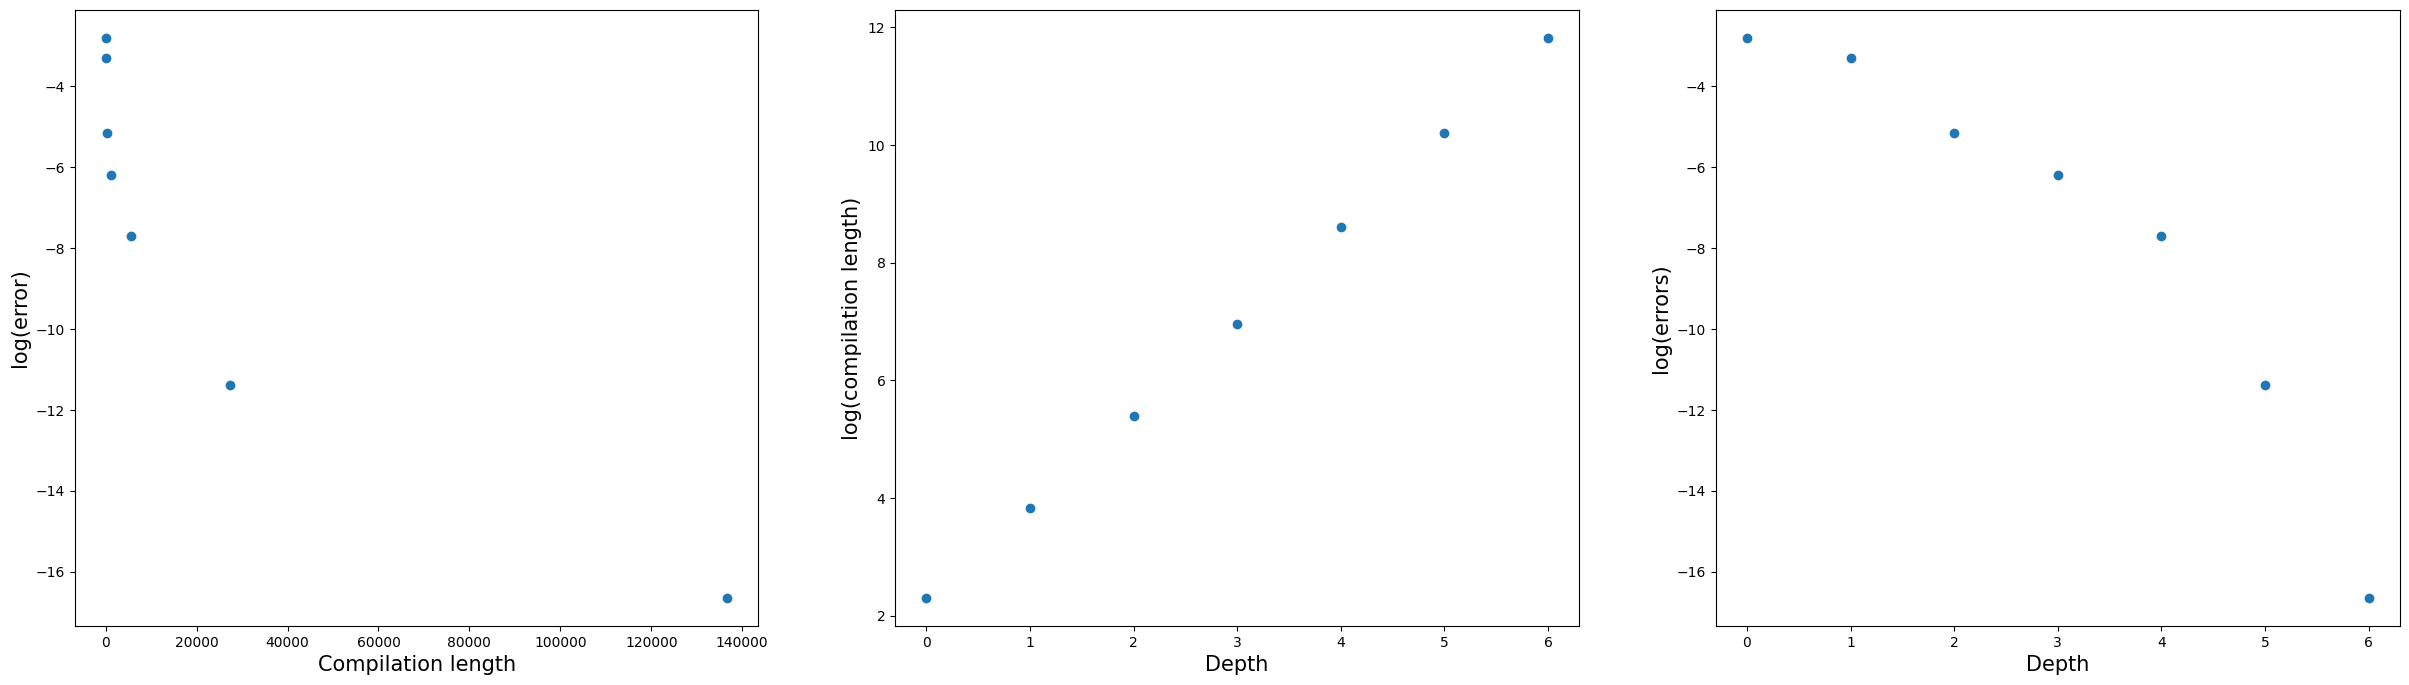

In [7]:
depth = 6
start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate,
                                 depth,
                                 net,
                                 epsilon_0=0.1,
                                 verbosity=3,
                                 scale=2, # This is a parameter that controls how to balance V and W, 
                                            # setting it to 2 usually is a good choice
                                 return_history=True)

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

# Plots how accuracy and compilation length evolve with the number of iterations
plot_history(hist)

The plots above confirm the expected dependencies of the SK parameters: the accuracy improves exponentially with circuit size, while doubly exponentially on the algorithm depth. 

## 1.4 Speeding up: the LSH method
Even with early stop, the execution of SK above is rather slow and `SKQudit` provides a few tricks to speed things up. The first consists in noticing that the better approximations are more likely to happen at upper layers than in the first one, so shuffling the net's list usually makes these good cases to show up first. 

Total search size:  3188644
|------------------------------| 0.6%Depth 0
Approxiation error: 0.0991273092977745
Number of gates: 12
|------------------------------| 0.0%
Error V: 0.09246604163030335
Error W: 0.08486833204209547
Depth 1
Approxiation error: 0.060661750461928225
Number of gates: 58
|------------------------------| 0.0%
Error V: 0.06039231501854943
Error W: 0.041238782509358744
Depth 2
Approxiation error: 0.014635013605581672
Number of gates: 294
|------------------------------| 0.3%
Error V: 0.008634928731452942
Error W: 0.026750411757519653
Depth 3
Approxiation error: 0.0035374791222807325
Number of gates: 1530
|------------------------------| 0.0%
Error V: 0.0018955015543663878
Error W: 0.001675773271152663
Depth 4
Approxiation error: 0.00014165624970246664
Number of gates: 7482
|------------------------------| 0.0%
Error V: 0.0004102321168002162
Error W: 7.439626925521219e-05
Depth 5
Approxiation error: 8.689381869898268e-06
Number of gates: 37626
|--------------------

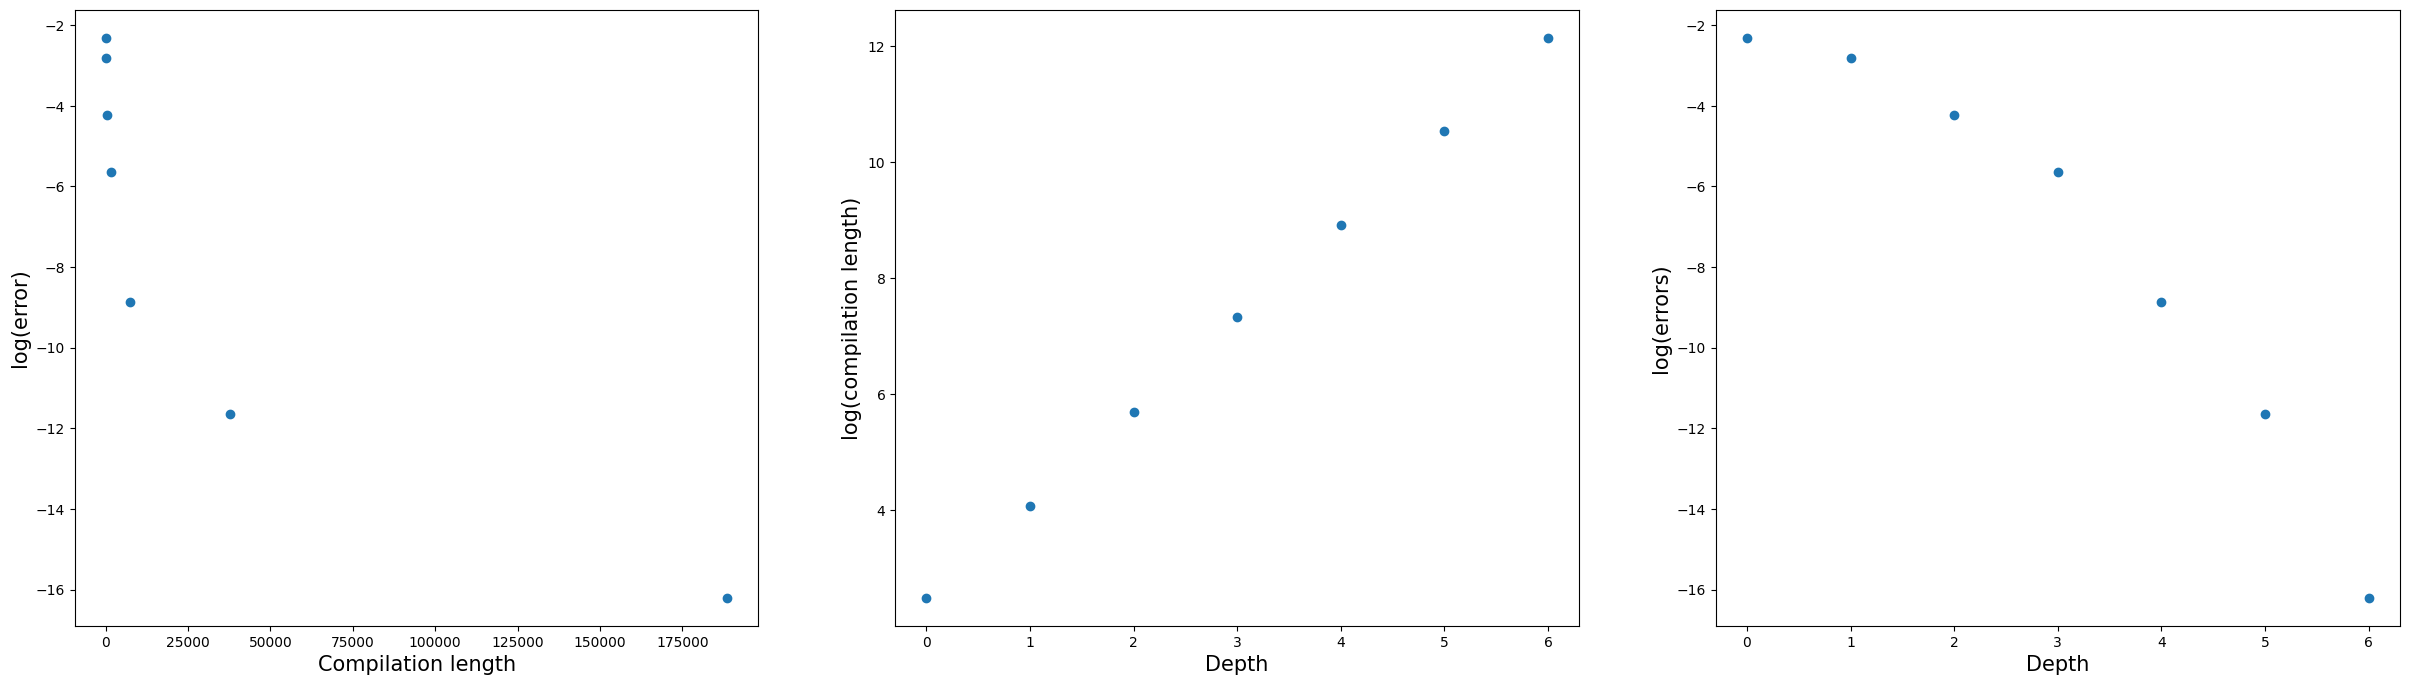

In [8]:
start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate,
                                 depth,
                                 net,
                                 epsilon_0=0.1,
                                 verbosity=3,
                                 scale=2,
                                 shuffle=True,
                                 return_history=True)

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

plot_history(hist)

For such a small net, the improvement of shuffling my not be so big, but it becomes more important as nets grow in size. 

Another important realization is that, at each run of the `net.search` subroutine, we visit the whole list of compiled gates for a given input $U$. Nonetheless, most of these gates are rather far from $U$ so it would be nice if we could, somehow, filter this search list to only the gates close to it. This is the main intuition behind [Local Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing): we split the space of matrices $SU(d)$ into buckets of neighbors. However, different from other neighbor methods such as [K-d trees](https://en.wikipedia.org/wiki/K-d_tree), it grows linearly the dimension $d$, making each much more appropriate for qubits (moreover, as it shall become clear in the discussion below, searches on this method *usually* can be done in constant time, whereas K-d tree searches are logarithmic on the number of elements of the search list on the best case scenarios).

To make the buckets, we use the fact, derived directly from the [Cauchy-Schwartz inequality](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality) that, if $V$ and $W$ are two matrices distant at most $\epsilon$, $|\langle V, R\rangle - \langle W, R\rangle|\leq \epsilon \|R\|$; in other words, similar matrices will have similar inner-products with any other matrix $R$. With this mind, we sample some $k$ $R$-matrices and take their inner products with the elements of the search list, ultimately putting each of the compilations inside *buckets*. When we want to find a compilation close to some target matrix $U$, we compute the product of $U$ with these $R$ matrices and, instead of comparing it with all the matrices of the search list, we compare only with the matrices on the bucket where $U$ lives. Alternatively, we could be a little more robust and compare $U$ not only with its bucket's elements, but also with neighboring buckets (it could happen, for example, that our target lies too close to the bucket's edges). If no close friend is found on the same bucket of $U$ or in its neighbor buckets, than we fall back to the usual linear search on the whole search list, therefore checking for false negatives. The code below implements LSH for our problem.

Total search size:  3188644
|------------------------------| 0.6%%Depth 0
Approxiation error: 0.0991273092977745
Number of gates: 12
|------------------------------| 0.0%
Error V: 0.0853074901698573
Error W: 0.09261983781962901
Depth 1
Approxiation error: 0.06426826934415468
Number of gates: 60
|------------------------------| 0.0%
Error V: 0.06093792245728222
Error W: 0.025190741099433426
Depth 2
Approxiation error: 0.035225743972460144
Number of gates: 308
|------------------------------| 0.0%%
Error V: 0.010423640290978309
Error W: 0.01153700461353306
Depth 3
Approxiation error: 0.008390914972079529
Number of gates: 1528
|------------------------------| 0.0%%
Error V: 0.0013734912516715286
Error W: 0.0037038381573585247
Depth 4
Approxiation error: 0.0007511004291837416
Number of gates: 7692
|------------------------------| 0.0%%
Error V: 0.0001244674985430095
Error W: 0.00012299270169344168
Depth 5
Approxiation error: 2.179932636190716e-05
Number of gates: 38600
|-------------------

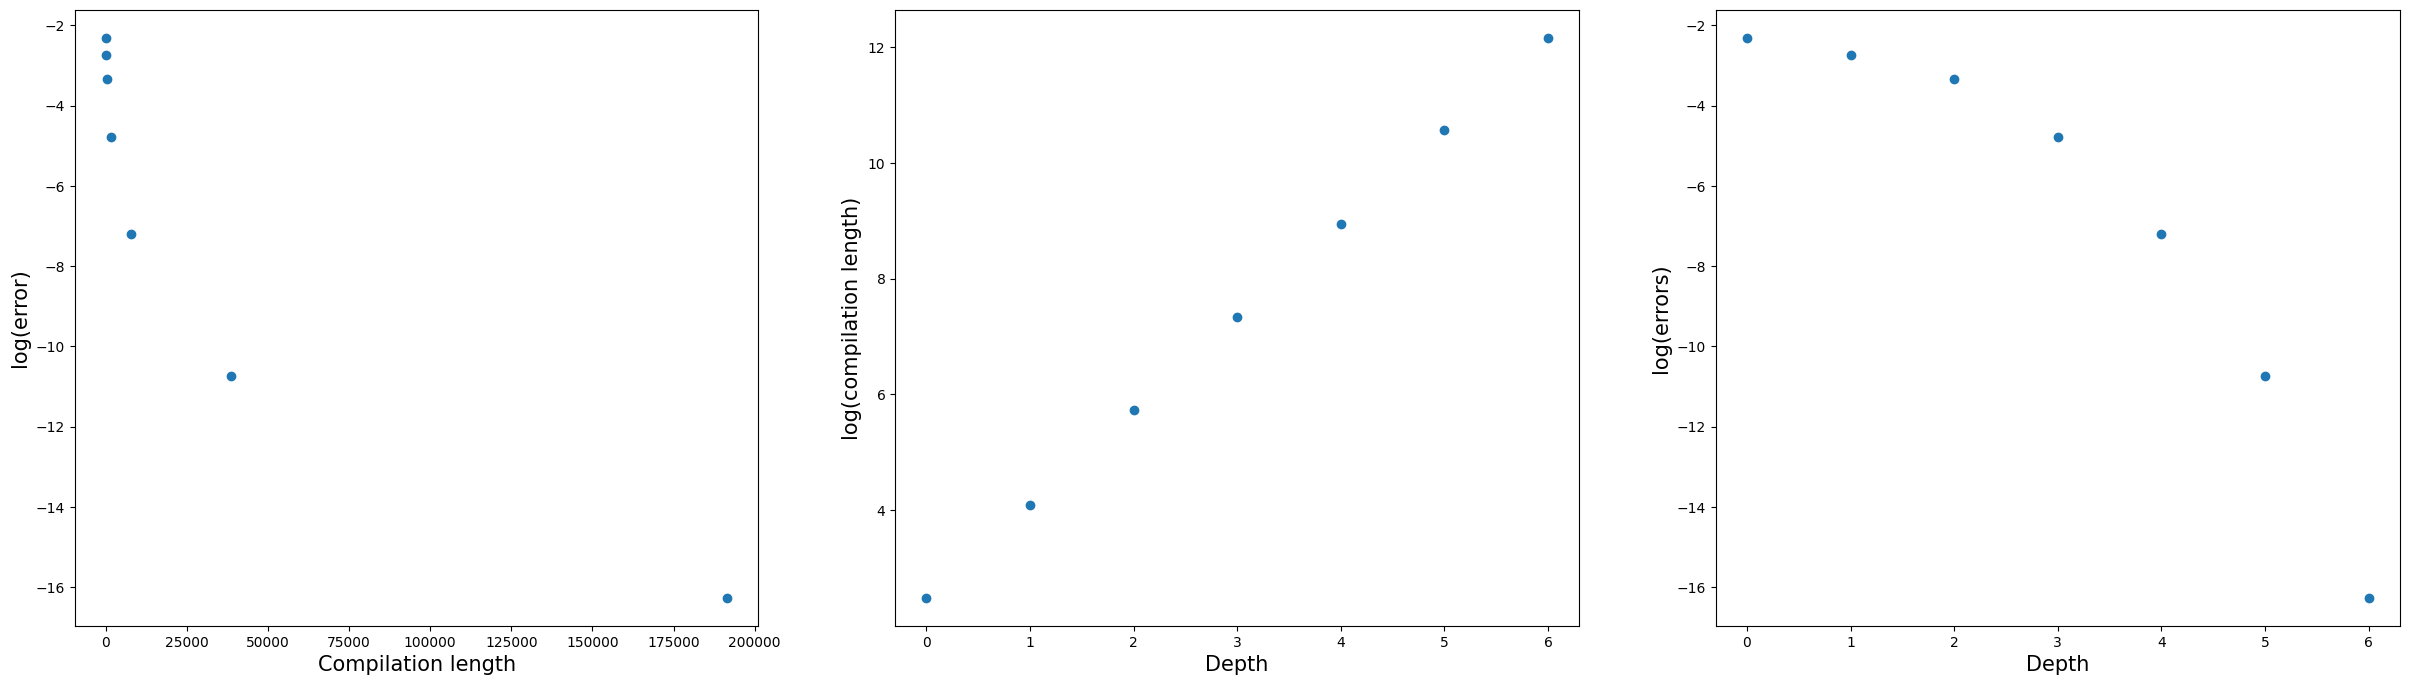

In [9]:
start = time.time()
bucket_params = {
    'k': 1, # Number of R matrices to sample
    'bucket_size': 0.01, # Bucket size, the smaller the more buckets we have
    'bucket_robustness': 0 # This parameter controls how many of the neighboring buckets to also consider
    }
best_gate, hist = solovay_kitaev(matrix_to_approximate,
                                 depth,
                                 net,
                                 epsilon_0=0.1,
                                 verbosity=3,
                                 scale=2,
                                 shuffle=True,
                                 bucket_params=bucket_params,
                                 return_history=True)

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

plot_history(hist)

We see that this is much already faster, but the gains are yet not so big as much of the computation is spent in taking the inner products of $R$. The gains really happen, however, when we decrease our net sizes while keeping the same effective accuracy. How this is done will be the topic of the next section.

## 1.5 Meet in the middle method
For 13 layers, we could construct a net that fits laptop usual memory, but there are times we will need to consider longer nets, which will occupy a significant portion of our memory. The [*meet in the middle*](https://www.geeksforgeeks.org/dsa/meet-in-the-middle/) approach allows us to consider compiled gates with twice the length of the used net. In particular, instead of directly searching for a compilation $\epsilon_0$-close to the matrix $U$, we 
1. compute $U\cdot V^\dagger$ for each gate $V$ in the search list;
2. look for an $\epsilon_0$-close compilation, $W \approx U\cdot V^\dagger$;
3. return $W\cdot V$ to approximate $U$.
Combined with LSH, this whole process not only requires less memory than the original search on the twice longer matrix, it is sometimes even faster. Below, we use a 7-layers only net to search the for an approximation of the current problem.

In [10]:
small_net = SimpleNet(instr_set=instr_set)
layers = int(1/2*layers)
_ = small_net.build_net(layers)
print('\nSize of small net:', len(small_net))


Size of small net: 4372


Total search size:  4372
|------------------------------| 0.0%

Depth 0
Approxiation error: 0.0940730439073434
Number of gates: 14
|------------------------------| 0.0%
Error V: 0.09137277005446287
Error W: 0.08907517703015447
Depth 1
Approxiation error: 0.054563101104491675
Number of gates: 58
|------------------------------| 0.0%
Error V: 0.046581828708084104
Error W: 0.044327121487080824
Depth 2
Approxiation error: 0.018048811581502098
Number of gates: 290
|------------------------------| 0.0%
Error V: 0.01232824557871131
Error W: 0.008500720639424982
Depth 3
Approxiation error: 0.0030453064745281557
Number of gates: 1502
|------------------------------| 0.2%
Error V: 0.004874492858157563
Error W: 0.0037174105000325765
Depth 4
Approxiation error: 0.0005968744462060388
Number of gates: 7790
|------------------------------| 0.0%
Error V: 0.0003216007081347517
Error W: 0.0018064695318243873
Depth 5
Approxiation error: 3.0006852743457665e-05
Number of gates: 39686
|------------------------------| 0.0%
Error V: 2.8856201036531026e-05
Error W: 1.63869

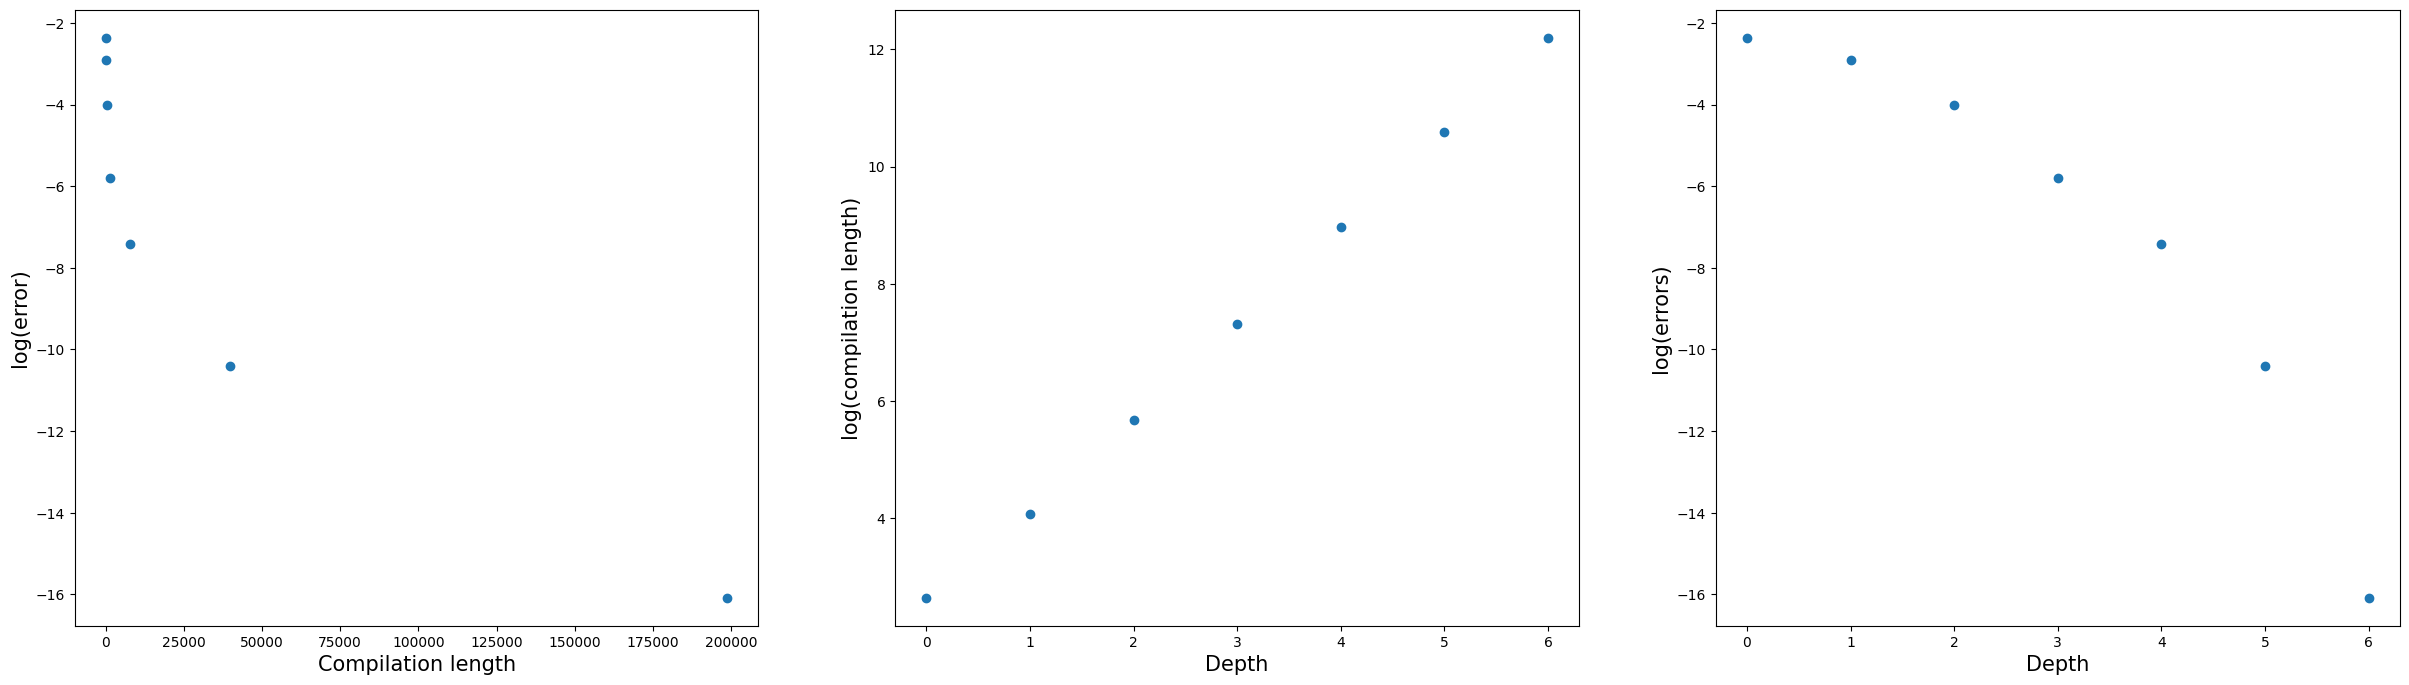

In [11]:
bucket_params = {
    'k': 3,
    'bucket_size': 0.01,
    'bucket_robustness': 0
    }
start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate, 
                                 depth, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 method='meet_in_the_middle',
                                 shuffle=True,
                                 bucket_params=bucket_params,
                                 return_history=True
                                 )

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')
plot_history(hist)

For the sake of comparison, let us see how slower it becomes when do not use the LSH in meet in the middle.

Total search size:  4372
|------------------------------| 0.0%Depth 0
Approxiation error: 0.0914978953322041
Number of gates: 14
|------------------------------| 0.5%
Error V: 0.09084746131527485
Error W: 0.08629693596289532
Depth 1
Approxiation error: 0.030828052561300678
Number of gates: 66
|------------------------------| 0.2%
Error V: 0.020826450414540603
Error W: 0.05021509526554614
Depth 2
Approxiation error: 0.011189153789624798
Number of gates: 310
|------------------------------| 0.0%
Error V: 0.015707249480395875
Error W: 0.024262828995369485
Depth 3
Approxiation error: 0.0011958209520087878
Number of gates: 1638
|------------------------------| 0.0%
Error V: 0.00389226655492485
Error W: 0.003410841877035239
Depth 4
Approxiation error: 0.0002127790508645354
Number of gates: 8198
|------------------------------| 0.0%
Error V: 0.000593057861685851
Error W: 0.00037206462612736813
Depth 5
Approxiation error: 1.187132088009305e-05
Number of gates: 40930
|--------------------------

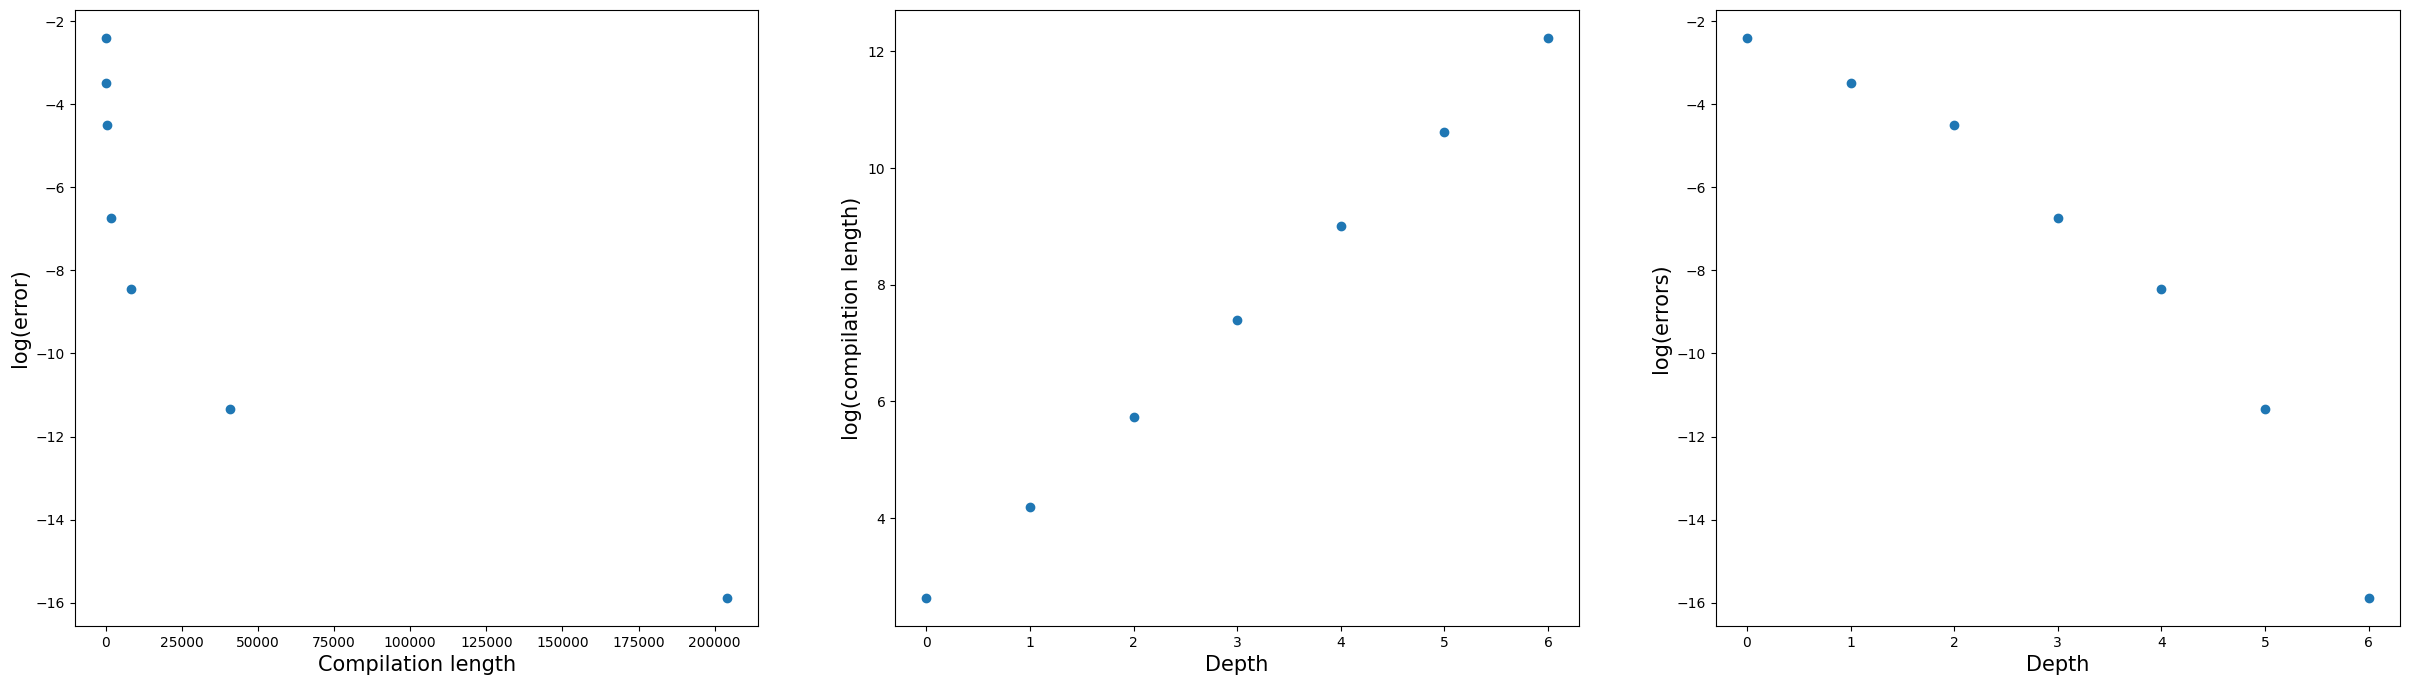

In [12]:
start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate, 
                                 depth, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 method='meet_in_the_middle',
                                 shuffle=True,
                                 bucket_params=None,
                                 return_history=True
                                 )

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

plot_history(hist)

Defenetely slower. For some examples, we were able to verify gains of more than half of the computation for the right choices of parameters.  

As a last trick, we note that most of the gates approximation use only the last layer of the net, instead of the full thing, to get appropriate depth 0 approximations. With this, we can restrict even more the set of searched gates by using only the net's last layer. 

Total search size:  2916
|------------------------------| 0.0%Depth 0
Approxiation error: 0.08737385434973877
Number of gates: 14
|------------------------------| 0.0%
Error V: 0.0894595811692094
Error W: 0.07919090149691371
Depth 1
Approxiation error: 0.052799004538162185
Number of gates: 70
|------------------------------| 0.0%
Error V: 0.034208361056940764
Error W: 0.05028280974121464
Depth 2
Approxiation error: 0.008706466850434118
Number of gates: 350
|------------------------------| 0.0%
Error V: 0.011548609464631331
Error W: 0.0049817780940455796
Depth 3
Approxiation error: 0.001635650464891207
Number of gates: 1750
|------------------------------| 0.0%
Error V: 0.0009509643995031179
Error W: 0.003541542459250406
Depth 4
Approxiation error: 6.032491862784138e-05
Number of gates: 8750
|------------------------------| 0.0%
Error V: 0.000411730544437951
Error W: 0.0003686621813942777
Depth 5
Approxiation error: 5.417245729022617e-06
Number of gates: 43750
|-------------------------

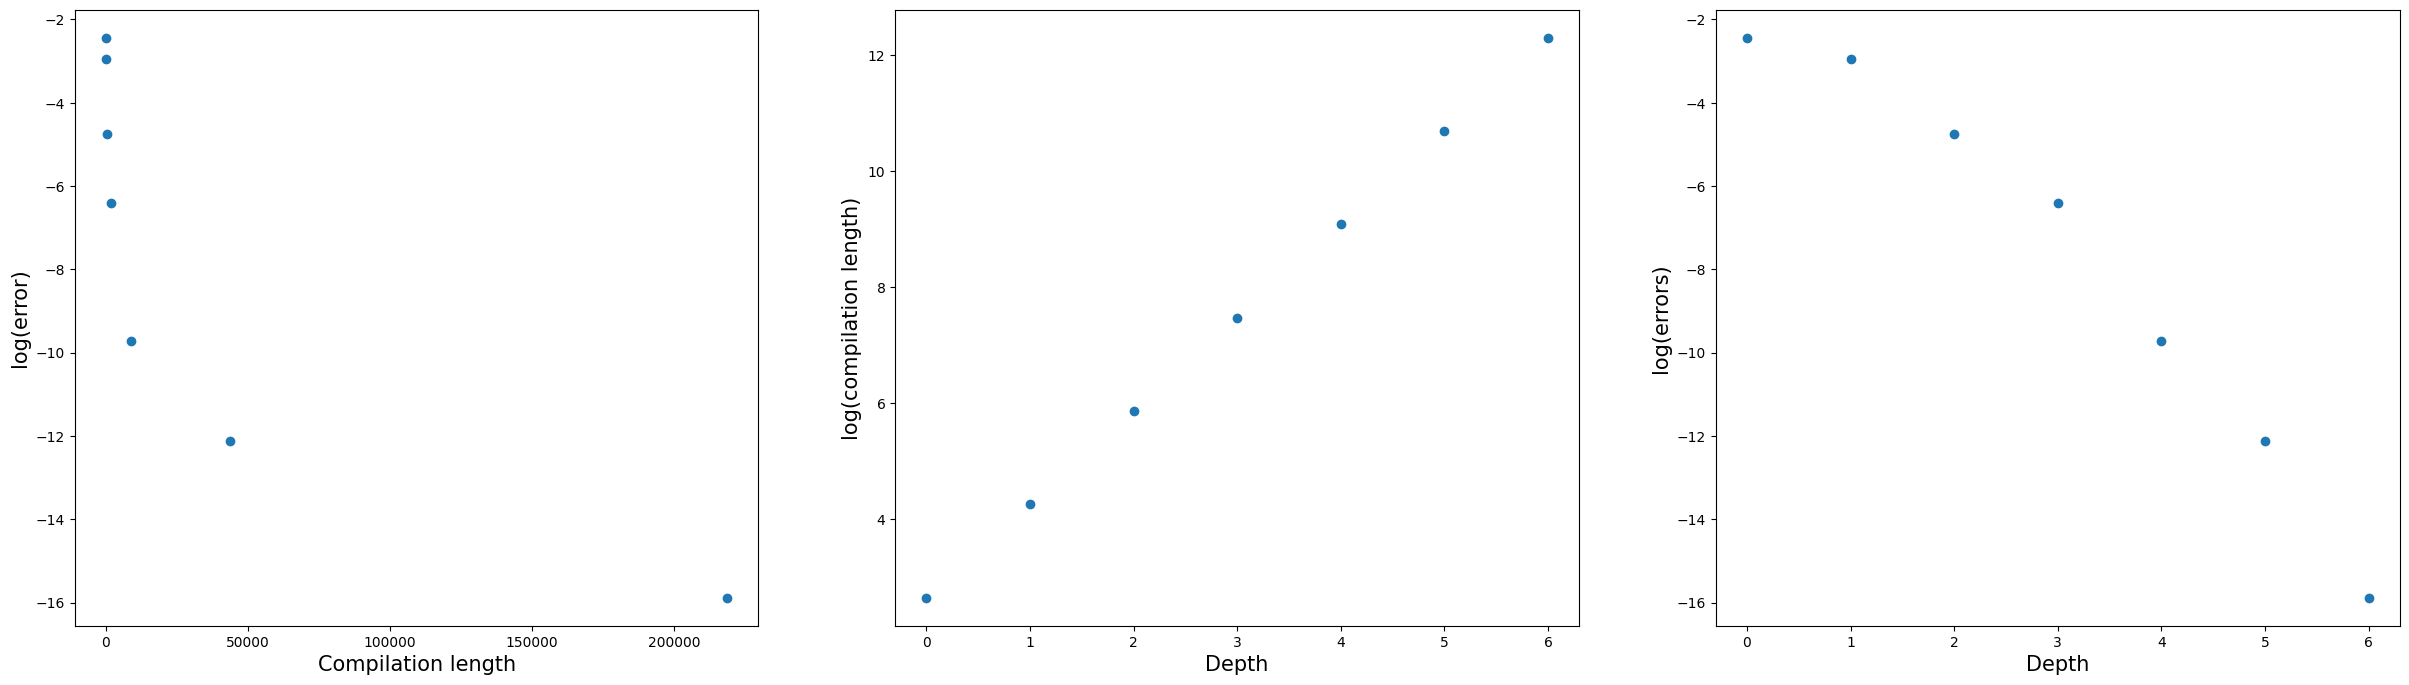

In [13]:
start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate, 
                                 depth, 
                                 small_net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 method='meet_in_the_middle',
                                 shuffle=True,
                                 bucket_params=bucket_params,
                                 scope='last_layer',
                                 return_history=True
                                 )

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

plot_history(hist)

# 2. Qudrit case
Up to now, we considered only qubits, that is, approximating matrices in $SU(2)$. Nonetheless, `SKQudit` becomes the more interesting when we use it to approximate gates that acts on quantum states of any finite dimension. These states naturally arise in some models of quantum computing, such as [topological quantum computing](https://en.wikipedia.org/wiki/Topological_quantum_computer), [trapped ion systems](https://en.wikipedia.org/wiki/Trapped-ion_quantum_computer), and [photonic computing](https://en.wikipedia.org/wiki/Linear_optical_quantum_computing). 

In this section, we will use qudrits gates to approximate a matrix in $SU(3)$. Although SK at the conceptual level is very different in the higher dimensional case, in terms of `SKQuid`, the code barely changes. Our first step is, therefore, to create a generating set. We will be using two of the exponents of the [Gell-Mann matrices](https://en.wikipedia.org/wiki/Gell-Mann_matrices), which can be thought of as generalization of Pauli.

In [2]:
s1, s2 = gell_mann_su3()

instr = {
    's1': s1,
       's2': s2
       }
instr_set = InstructionSet(instr)

print('Instructions: ', instr_set.instrs)

Instructions:  ['s1', 's2', 'S1', 'S2']


A net of size 10 (so effective size 20) should be enough.

In [77]:
layers = 12
net = SimpleNet(instr_set)
_ = net.build_net(layers, verbosity=1)
print('\nSize of net:', len(net))

Progress: layer 13 of 13

Size of net: 3188644


We will generate a random $3\times 3$ matrix to approximate.

In [73]:
matrix_to_approximate = su_matrix(3, # Dimension
                                  seed=42) # This ensures reproducibility
matrix_to_approximate

array([[ 0.41583969-0.40006092j, -0.32724802-0.33413518j,
         0.2073982 +0.63661371j],
       [ 0.5177037 +0.3045415j , -0.65294335+0.37173924j,
        -0.09324002-0.2569408j ],
       [ 0.31673322-0.45381278j,  0.05506039-0.46228313j,
        -0.05514194-0.68844466j]])

Let us check if we can approximate this matrix at the accuracy of $0.1$ at level 0. Of course, this does not guarantee that the whole SK will converge, but is a requirement for that.

In [ ]:
depth=1
bucket_params = {
    'k': 1,
    'bucket_size': 0.1,
    'bucket_robustness': 0
    }

start = time.time()

best_gate, hist = solovay_kitaev(matrix_to_approximate, 
                                 depth, 
                                 net, 
                                 epsilon_0 = 0.1, 
                                 verbosity = 3, 
                                 scale = 2, 
                                 method='meet_in_the_middle',
                                 shuffle=True,
                                 bucket_params=bucket_params,
                                 scope='last_layer',
                                 return_history=True
                                 )

end = time.time()
print('Execution time:', round(end - start, 2), 'seconds')

plot_history(hist)

# 3. Clifford + T
We now explore the universal set Clifford + T. This set is interesting because, as we will see, elements close to the identity only start showing up at very high layers of the net's tree. Let us first try building a very deep net and using linear search.

In [14]:
s1 =  1j/np.sqrt(2)*np.array([[1, 1], [1, -1]])
s2 = np.diag([np.exp(-1j*np.pi/8), np.exp(1j*np.pi/8)])
S2 = np.diag([np.exp(1j*np.pi/8), np.exp(-1j*np.pi/8)])
print('Determinant of gates: ',
      np.linalg.det(s1), np.linalg.det(s2), np.linalg.det(S2))
instr_set = {'s1': s1, 'S1': s1, 's2': s2, 'S2': S2}
instr_set = InstructionSet(instr_set, inverses_provided=True)

Determinant of gates:  (0.9999999999999999+0j) (1+0j) (1+0j)
